# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Для работы у нас имеются следующие данные:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

## Шаг 1. Откройте файл с данными и изучите общую информацию

Импортируем необходимые библиотеки, задаем формат отображения дробных чисел.

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Начнем с получения самой общей информации о файле и данных, которые оказались в нашем распоряжении.

In [2]:
estate = pd.read_csv('real_estate_data.csv', sep='\t', decimal='.')
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Файл представляет собой таблицу, в которой содержатся 22 столбца и 23699 строк. Значения разделены при помощи группы символов "\t". Уже сейчас можно сказать, что в таблице содержится большое количество пропусков, а тип данных в некоторых столбцах не является оптимальным. Например, число этажей не может быть дробным числом, здесь скорее подошел бы целочисленный тип данных.

Удостоверимся, что названия столбцов из csv-файла соответствуют заявленным в задании. Так как количество столбцов, а их 22, достаточно велико, автоматизируем проверку с помощью комбинации методов columns (который возвращает в виде списка названиях всех столбцов реальной таблицы) и isin(), который поможет удостовериться в том, что элементы списка столбцов, полученного описанным ранее методом, содержатся в списке столбцов из задания, составленном вручную.

In [3]:
column_list = ['airports_nearest', 'balcony', 'ceiling_height', 'cityCenters_nearest', 'days_exposition',
               'first_day_exposition', 'floor', 'floors_total', 'is_apartment', 'kitchen_area', 'last_price',
               'living_area', 'locality_name', 'open_plan', 'parks_around3000', 'parks_nearest', 'ponds_around3000',
               'ponds_nearest', 'rooms', 'studio', 'total_area', 'total_images']
check = estate.columns.isin(column_list)
check

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

В получившемся булевом массиве все элементы имеют значение "True". Значит, расхождений между названия столбцов из задания и из таблицы нет. Взглянем на несколько строк из таблицы.

In [4]:
estate.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Данные экспортированы корректно, но в них содержатся пропуски, тип данных для некоторых столбцов выбран неверно. Логично предположить, что встречаются и другие ошибки/неточности, от которых необходимо будет избавиться на этапе предобработки данных.

## Шаг 2. Предобработка данных

В рамках этапа предобработки имеющихся данных по очереди проверим все столбцы на наличие пропусков, некорректных значений и прочих проблем.

### Количество фотографий

In [5]:
estate['total_images'].describe()

count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

В столбце 'total_images' содержится информация о количестве фотографий, прикрепленных к объявлению для каждого объекта недвижимости. Диапазон значений — от 0 до 50. Аномальных значений нет, тип данных указан верно (его берем из описания таблицы с помощью метода info()). Количество фотографий может быть только целым числом. Пропусков нет.

### Последняя актуальная цена

In [6]:
estate['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

В столбце 'last_price' указана цена на момент снятия квартиры с продажи. Все строки заполнены, однако минимальное и максимальное значения сильно выбиваются из общего порядка цен. Следует проверить, не закралась ли в данные ошибка. Тип данных также подобран неоптимально. Переведем данные в целочисленный тип с помощью метода astype() и его параметра 'int'.

In [7]:
estate['last_price'] = estate['last_price'].astype('int')

Взглянем на минимальные и максимальные значения в столбце. Сразу видно, что есть всего одна квартира с ценой менее 430 000 рублей и стоит она подозрительно мало — всего 12 190 рублей. А вот сверхдорогих квартир в таблице несколько, такие значения тоже настораживают.

In [8]:
estate['last_price'].sort_values()

8793         12190
17456       430000
14911       430000
16274       440000
17676       450000
           ...    
15651    300000000
1436     330000000
14706    401300000
19540    420000000
12971    763000000
Name: last_price, Length: 23699, dtype: int32

Получим более подробные данные о квартире стоимостью 12 190 рублей. 

In [9]:
estate.query('last_price == 12190')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


Очевидно, что в этом случае была допущена ошибка — пропущены три нуля на конце. Заменим ее цену на 12 190 000, проверим правильность замены. Очевидно, что это ошибка со стороны человека, разместившего объявление, дополнительных действий с нашей стороны по устранению подобных ошибок не требуется.

In [10]:
estate['last_price'] = estate['last_price'].replace(12190, 12190000)
estate['last_price'].sort_values()

17456       430000
14911       430000
16274       440000
17676       450000
9581        450000
           ...    
15651    300000000
1436     330000000
14706    401300000
19540    420000000
12971    763000000
Name: last_price, Length: 23699, dtype: int32

Теперь более подробно изучим квартиры, стоимостью более 50 миллионов рублей.

In [11]:
len(estate.query('last_price > 50000000'))

131

In [12]:
len(estate.query('last_price < 50000000')) / len(estate)

0.9941769694923837

Квартир стоимостью более 50 миллионов рублей насчитывается только 131 штука. Сложно сказать, содержатся ли в данном столбце ошибочные значения, но аномальные выбросы имеются точно. Отметим, что подавляющее большинство наблюдений (99,4%) попадают в ценовую категорию "менее 50 миллионов рублей".

Построим гистограмму для данного столбца.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002108681B408>]],
      dtype=object)

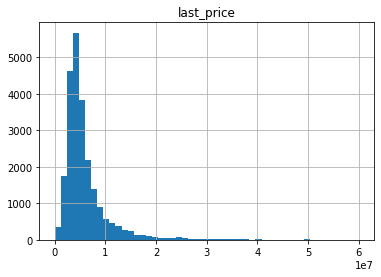

In [13]:
estate.hist(column='last_price', bins=50, range=(0,60000000))

Количество объектов недвижимости стоимостью более 50 млн. рублей невелико (131 штука или менее 0,6% от всех наблюдений), однако они могут существенно исказить общую картину. На данном этапе не удаляем их, т. к. выбросами мы займемся позже, однако учтем их наличие.

### Общая площадь

In [14]:
estate['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

В столбце 'total_area', отвечающем за общую площадь квартиры, все значения на месте, видимых аномалий нет. Тип данных float, уже присвоенный данному столбцу, поможет более точно оценить влияние метража на прочие показатели, особенно для квартир с небольшой площадью, соответственно оставляем без изменений.

### Дата публикации объявления

Взглянем на столбец 'first_day_exposition', отвечающий за дату размещения объявления о продаже. Отметим, что формат указан неверно. Переведем значения столбца в формат datetime с помощью метода to_datetime(). 

In [15]:
estate['first_day_exposition']

0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23699, dtype: object

In [16]:
estate['first_day_exposition'] = pd.to_datetime(estate['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
estate['first_day_exposition'].describe()

count                   23699
unique                   1491
top       2018-02-01 00:00:00
freq                      368
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

В остальном данные выглядят правдоподобно, пропусков нет. Также можно сказать, что информация собиралась в течение последних 5 лет: с 2014 года по 2019 год.

### Количество комнат

In [17]:
estate['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [18]:
estate['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

В столбце 'rooms' содержится информация о количестве комнат в квартире. Пропусков нет, целочисленный тип данных как нельзя лучше подходит этому показателю. Однако в столбце сразу же видны определенные аномалии: жилые объекты с числом комнат меньше 0 и квартиры с очень большим числом комнат. Проверим значения в данном столбце с помощью гистограммы и графика типа "ящик с усами".

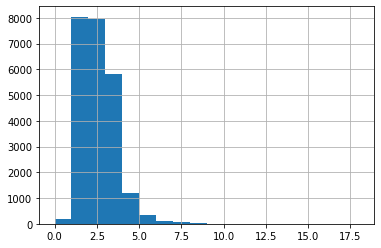

In [19]:
estate['rooms'].hist(bins=18, range=(0, 18))

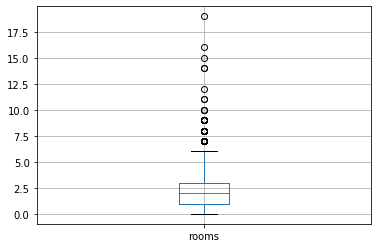

In [20]:
estate.boxplot(column=['rooms'])

Указанных выше объектов совсем немного, но они могут негативно повлиять на результаты исследования (так как определенно являются выбросами). На данном этапе не будем удалять выбросы, а сделаем это на этапе анализа данных. Однако удалим квартиры с 0 комнат, так как их немного, а в данных при заполнении подобных объявлений явно была допущена ошибка (возможно, этот пункт был просто пропущен). Проверим.

In [21]:
estate = estate.query('0 < rooms')
estate['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
6      105
7       59
8       12
9        8
10       3
14       2
11       2
15       1
12       1
19       1
16       1
Name: rooms, dtype: int64

Взглянем на обновленные данные по таблице.

In [22]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23502 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23502 non-null  int64         
 1   last_price            23502 non-null  int32         
 2   total_area            23502 non-null  float64       
 3   first_day_exposition  23502 non-null  datetime64[ns]
 4   rooms                 23502 non-null  int64         
 5   ceiling_height        14422 non-null  float64       
 6   floors_total          23419 non-null  float64       
 7   living_area           21613 non-null  float64       
 8   floor                 23502 non-null  int64         
 9   is_apartment          2769 non-null   object        
 10  studio                23502 non-null  bool          
 11  open_plan             23502 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Количество этажей

Изменим порядок обработки столбцов. Сначала рассмотрим столбец 'floors_total' и только потом перейдем к работе со столбцом 'ceiling_height', так как количество этажей может помочь в заполнении пропусков в графе "высота потолков".

In [23]:
estate['floors_total'].describe()

count    23419.000000
mean        10.622273
std          6.569964
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [24]:
estate['floors_total'].isna().sum()

83

В данном столбце 83 пропущенных значения. Тип данных float не соответствует содержащейся в столбце информации, т. к. количество этажей — всегда целое число. Избавимся от пропусков методом dropna(). В данном случае замена пропусков на медианные значения не является оптимальным решением, потому что это может в последующем помешать корректному распределению квартир по категориям "Первый этаж", "Последний этаж", "Другое".

Избавимся от строк с пропущенными значениями, заменим тип данных в столбце на целочисленный, выполним проверку и уточним актуальное состояние таблицы с помощью метода info().

In [25]:
estate.dropna(subset=['floors_total'], inplace=True)
estate['floors_total'].isna().sum()

0

In [26]:
estate['floors_total'] = estate['floors_total'].astype('int')

In [27]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23419 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23419 non-null  int64         
 1   last_price            23419 non-null  int32         
 2   total_area            23419 non-null  float64       
 3   first_day_exposition  23419 non-null  datetime64[ns]
 4   rooms                 23419 non-null  int64         
 5   ceiling_height        14413 non-null  float64       
 6   floors_total          23419 non-null  int32         
 7   living_area           21560 non-null  float64       
 8   floor                 23419 non-null  int64         
 9   is_apartment          2769 non-null   object        
 10  studio                23419 non-null  bool          
 11  open_plan             23419 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

### Высота потолков

In [28]:
estate['ceiling_height'].describe()

count    14413.000000
mean         2.769602
std          1.248488
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [29]:
estate['ceiling_height'].value_counts()

2.50      3513
2.60      1637
2.70      1551
3.00      1108
2.55       979
          ... 
2.25         1
4.15         1
4.14         1
1.75         1
100.00       1
Name: ceiling_height, Length: 182, dtype: int64

Столбец 'ceiling_height' содержит информацию о высоте потолков в квартире. Тип данных float выбран корректно, но в столбце не хватает около трети значений. Наличие пропусков, скорее всего, связано с тем, что не все пользователи заполняют эту графу при подготовке объявлений.

Так как многие 5- и 9-этажные дома построены по типовым советским проектам, то и высота потолков в таких домах будет более однородной, чем для всей выборки в целом. То же можно сказать и про новые 25-этажные дома новой постройки (например, на Парнасе или в Девяткино), возведенные по единому проекту. Заполним пропуски медианным значением в зависимости от количества этажей  в доме. Данный метод, однако, не будет работать, если в объявлении не указана высота потолков, а других домов такой же этажности в таблице нет.

In [30]:
median_heights = estate.groupby('floors_total')['ceiling_height'].median()
median_heights

floors_total
1      2.80
2      2.70
3      2.80
4      3.00
5      2.55
6      3.00
7      3.00
8      2.80
9      2.55
10     2.60
11     2.75
12     2.65
13     2.70
14     2.60
15     2.70
16     2.70
17     2.70
18     2.70
19     2.75
20     2.75
21     2.70
22     2.75
23     2.75
24     2.75
25     2.75
26     2.67
27     2.70
28     2.60
29     2.60
33      NaN
34     2.65
35     2.70
36    14.85
37     1.75
52     2.65
60     2.88
Name: ceiling_height, dtype: float64

В данном случае проблемы могут возникнуть с 33-этажным объектом (объектами), так как для него отсутствует медианное значение. Его заполним медианным значением для всего столбца.

In [31]:
estate['ceiling_height'] = (estate
                            .groupby('floors_total')['ceiling_height']
                            .transform(lambda x: x.fillna(x.median()) if (x.isnull().sum() != len(x)) else x ))
estate['ceiling_height'] = estate['ceiling_height'].fillna(estate['ceiling_height'].median())
estate['ceiling_height'].describe()

count    23419.000000
mean         2.734752
std          0.987252
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

Можно заметить, что в столбце присутствуют аномально высокие и низкие значения. Так как речь идет о продаже квартир, то есть жилой недвижимости, маловероятным представляется существование объектов с высотой потолка 1 метр или 100 метров. Скорее всего, в данных присутствует ошибка. Проверим количество объектов с чрезмерно высокой или низкой высотой потолков.

In [32]:
len(estate.query('ceiling_height < 2.4'))

21

In [33]:
len(estate.query('ceiling_height > 5'))

35

В таблице всего 21 объект недвижимости, высота потолков которых меньше 2,4 метров (стандартная высота потолка в "хрущевке" — 2,48 метра, по нормам СНиП 31-01-2003 высота потолков в многоквартирных жилых домах должна быть не менее 2,5 метра), и 31 объект с высотой потолков более 5 метров.

Мало того, что данные наблюдения могут содержать ошибки, они также могут считаться выбросами и удалены как статистически незначимые, тем более, их количество очень невелико.

In [34]:
estate = estate.query('ceiling_height >= 2.4 & ceiling_height <= 5')
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23363 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23363 non-null  int64         
 1   last_price            23363 non-null  int32         
 2   total_area            23363 non-null  float64       
 3   first_day_exposition  23363 non-null  datetime64[ns]
 4   rooms                 23363 non-null  int64         
 5   ceiling_height        23363 non-null  float64       
 6   floors_total          23363 non-null  int32         
 7   living_area           21509 non-null  float64       
 8   floor                 23363 non-null  int64         
 9   is_apartment          2752 non-null   object        
 10  studio                23363 non-null  bool          
 11  open_plan             23363 non-null  bool          
 12  kitchen_area          21336 non-null  float64       
 13  balcony         

### Жилая площадь

In [35]:
estate['living_area'].describe()

count    21509.000000
mean        34.582496
std         22.034205
min          2.000000
25%         18.700000
50%         30.000000
75%         42.500000
max        409.700000
Name: living_area, dtype: float64

Столбцу 'living_area' подходит тип данных float, принадлежащий ему по умолчанию, т. к. площадь помещений не всегда является целым числом. В столбце содержится определенное количество пропусков, которое можно заполнить медианными значениями жилой площади для квартир с тем же количеством комнат. Проверяем правильность выполнения операции методом describe().

In [36]:
estate['living_area'] = (estate
                            .groupby('rooms')['living_area']
                            .transform(lambda x: x.fillna(x.median()) if (x.isnull().sum() != len(x)) else x ))
estate['living_area'] = estate['living_area'].fillna(estate['living_area'].median())
estate['living_area'].describe()

count    23363.000000
mean        34.446888
std         21.707082
min          2.000000
25%         18.500000
50%         30.500000
75%         42.900000
max        409.700000
Name: living_area, dtype: float64

### Этаж

In [37]:
estate['floor'].describe()

count    23363.000000
mean         5.856397
std          4.853258
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

В данном столбце нет пропущенных значений, целочисленный тип данных выбран верно, данные выглядят адекватно. Стоит проверить, нет ли в таблице квартир, этаж которых больше этажности самого дома. Выясняем, что таких квартир нет.

In [38]:
len(estate.loc[estate['floor'] > estate['floors_total']])

0

### Апартаменты

In [39]:
estate['is_apartment'].value_counts()

False    2705
True       47
Name: is_apartment, dtype: int64

По данным столбца к типу "апартаменты" принадлежат всего 47 объектов недвижимости. Однако для большинства квартир этот параметр не указан в принципе. Пропуски в этом столбце невозможно заполнить на основании других столбцов, поэтому мы оставим его без изменений. Можно было бы предположить, что все пропущенные значения — это квартиры, не относящиеся к апартаментам, но соотношение апартаментов и общего числа объектов недвижимости в таком случае получается неправдоподобно низким. Получается, что часть пользователей просто забыла или намеренно не вписала в эту графу необходимое значение. Анализ будем проводить по имеющимся значениям.

Указанный тип данных object не подходит, так как в данном столбце содержится булева переменная. Изменим тип данных на bool, проверим.

In [40]:
estate['is_apartment'] = estate['is_apartment'].replace('True', True)
estate['is_apartment'] = estate['is_apartment'].replace('False', False)
estate['is_apartment'].value_counts()

False    2705
True       47
Name: is_apartment, dtype: int64

### Квартиры-студии

In [41]:
estate['studio'].value_counts()

False    23352
True        11
Name: studio, dtype: int64

Данный столбец, как и требуется, уже ассоциирован с логическим типом данных. Пропусков не наблюдается. Однако стоит проверить, все ли квартиры, отмеченные как студии, действительно имеют только одну комнату.

In [42]:
len(estate.query('studio == True & rooms > 1'))

0

Все квартиры, отмеченные как студии, имеют только одну комнату. Значит, ошибок в данных нет.

### Открытая планировка

In [43]:
estate['open_plan'].value_counts()

False    23355
True         8
Name: open_plan, dtype: int64

Данный столбец также ассоциирован с булевым типом данных, изменения не требуются. Пропусков нет.

### Площадь кухни

In [44]:
estate['kitchen_area'].describe()

count    21336.000000
mean        10.563880
std          5.895704
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Как и другие столбцы с площадью, этот имеет тип данных float, который нам подходит. В столбце имеется определенное количество пропусков. заполним их на основании данных об общей площади квартир. Очевидно, что таким образом удастся заполнить далеко не все пропуски. Оставшиеся заполним медианными значениями для всего столбца 'kitchen_area'.

In [45]:
estate['kitchen_area'] = (estate
                            .groupby('total_area')['kitchen_area']
                            .transform(lambda x: x.fillna(x.median()) if (x.isnull().sum() != len(x)) else x ))
estate['kitchen_area'] = estate['kitchen_area'].fillna(estate['kitchen_area'].median())
estate['kitchen_area'].describe()

count    23363.000000
mean        10.473122
std          5.766121
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64

### Количество балконов

In [46]:
estate['balcony'].describe()

count    11973.000000
mean         1.148250
std          1.072538
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

In [47]:
estate['balcony'].value_counts()

1.0    4152
0.0    3697
2.0    3560
5.0     301
4.0     182
3.0      81
Name: balcony, dtype: int64

В столбце 'balcony' содержится информация о количестве балконов в квартире. Многие значения пропущены. Можем предположить, что пропуски наблюдаются в тех случаях, когда количество балконов равно нулю и человек, размещающий объявление, именно поэтому не заполнил данную графу. Заполним пропуски и заменим тип данных на целочисленный (количество балконов — всегда целое число). Проверим.

In [48]:
estate['balcony'] = estate['balcony'].fillna(0)
estate['balcony'] = estate['balcony'].astype('int')
estate['balcony'].value_counts()

0    15087
1     4152
2     3560
5      301
4      182
3       81
Name: balcony, dtype: int64

### Населенный пункт

Столбцу 'locality_name' присвоен тип object, который как нельзя лучше подходит названиям населенных пунктов. Получим более подробную информацию о столбце разными методами.

In [49]:
estate['locality_name'].describe()

count               23315
unique                361
top       Санкт-Петербург
freq                15513
Name: locality_name, dtype: object

In [50]:
estate['locality_name'].value_counts().head(30)

Санкт-Петербург            15513
посёлок Мурино               493
посёлок Шушары               435
Всеволожск                   391
Пушкин                       369
Колпино                      338
посёлок Парголово            323
Гатчина                      306
деревня Кудрово              283
Выборг                       235
Петергоф                     201
Сестрорецк                   183
Красное Село                 175
Кудрово                      165
деревня Новое Девяткино      142
Сертолово                    139
Ломоносов                    133
Кириши                       125
Сланцы                       112
Волхов                       110
Кингисепп                    104
Тосно                        102
Кронштадт                     95
Коммунар                      89
Никольское                    87
Сосновый Бор                  86
Кировск                       84
Отрадное                      79
посёлок Бугры                 67
Приозерск                     66
Name: loca

В столбце сразу же можно заметить ряд проблем: различное написание одних и тех же слов ("поселок" и "посёлок"), упоминание/отсутствие типа населенного пункта. Ряд значений отсутствует. Отсутствующие значения заменим на значение "неизвестно".

In [51]:
estate['locality_name'] = estate['locality_name'].fillna('Неизвестно')
len(estate.query('locality_name == "Неизвестно"'))

48

В рамках задания от нас требуется составить топ-10 населенных пунктов по количеству объявлений. Разница в написании может исказить результаты. Проанализировав топ-30 населенных пунктов по количеству объявлений, выясним, что только Кудрово встречается в двух разных написаниях. Все остальные позиции упомянуты по одному разу. Исправим это.

In [52]:
estate['locality_name'] = estate['locality_name'].replace('деревня Кудрово', 'Кудрово')
estate['locality_name'].value_counts().head(30)

Санкт-Петербург            15513
посёлок Мурино               493
Кудрово                      448
посёлок Шушары               435
Всеволожск                   391
Пушкин                       369
Колпино                      338
посёлок Парголово            323
Гатчина                      306
Выборг                       235
Петергоф                     201
Сестрорецк                   183
Красное Село                 175
деревня Новое Девяткино      142
Сертолово                    139
Ломоносов                    133
Кириши                       125
Сланцы                       112
Волхов                       110
Кингисепп                    104
Тосно                        102
Кронштадт                     95
Коммунар                      89
Никольское                    87
Сосновый Бор                  86
Кировск                       84
Отрадное                      79
посёлок Бугры                 67
Приозерск                     66
посёлок Металлострой          65
Name: loca

Благодаря этой операции Кудрово перебралось с 9 на 3 место. Все позиции после 30 будем считать слишком незначительными, чтобы заметно повлиять на первую десятку самых популярных населенных пунктов.

### Расстояние до ближайшего аэропорта

In [53]:
estate['airports_nearest'].describe()

count    17932.000000
mean     28817.737843
std      12624.489501
min          0.000000
25%      18585.000000
50%      26763.500000
75%      37275.500000
max      84869.000000
Name: airports_nearest, dtype: float64

Сразу же можем сказать, что в столбце содержатся пропуски. Тип данных int здесь бы подошел лучше, так как расстояние и так указано в метрах. Заменим пропуски на медианные значения для каждого населенного пункта. Для тех наблюдений, для которых данный метод не подходит (например, по причине того что соответствующей группы для них не нашлось), — медианными значениями всего столбца.

In [54]:
estate['airports_nearest'] = (estate
                            .groupby('locality_name')['airports_nearest']
                            .transform(lambda x: x.fillna(x.median()) if (x.isnull().sum() != len(x)) else x ))
estate['airports_nearest'] = estate['airports_nearest'].fillna(estate['airports_nearest'].median())
estate['airports_nearest'].describe()

count    23363.000000
mean     28345.795296
std      11098.107395
min          0.000000
25%      21189.000000
50%      26786.000000
75%      34424.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [55]:
estate.query('airports_nearest == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,NaN,...,6.0,2,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


Нулевое значение, хоть и вызывает вопросы, встречается только единожды и само по себе не может считаться ошибкой. Петербургский аэропорт (а именно здесь расположена данная квартира) находится в черте города, в непосредственной близости от него есть жилые дома.

### Расстояние до центра города

Столбец отвечает за расстояние от объекта недвижимости до центра города. Получим более подробную информацию.

In [56]:
estate['cityCenters_nearest'].describe()

count    17955.000000
mean     14192.092732
std       8631.366031
min        181.000000
25%       9233.000000
50%      13087.000000
75%      16289.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Для заполнения пропусков повторим операции, произведенные для предыдущего столбца. В данном случае, однако, не будем заполнять оставшиеся пропуски медианным значением для всего столбца, т. к. это может негативно сказаться на точности данных.

In [57]:
estate['cityCenters_nearest'] = (estate
                            .groupby('locality_name')['cityCenters_nearest']
                            .transform(lambda x: x.fillna(x.median()) if (x.isnull().sum() != len(x)) else x ))
estate['cityCenters_nearest'].describe()

count    18031.000000
mean     14191.732405
std       8626.914178
min        181.000000
25%       9238.000000
50%      13063.000000
75%      16275.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

### Число парков в радиусе 3 км

In [58]:
estate['parks_around3000'].describe()

count    17956.000000
mean         0.612998
std          0.802590
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [59]:
estate['parks_around3000'].value_counts()

0.0    9961
1.0    5624
2.0    1730
3.0     641
Name: parks_around3000, dtype: int64

Скорее всего, пропуски в данном столбце связаны с нулевыми значениями, то есть отсутствием парков в радиусе 3-х километров для данных объектов недвижимости. Проведем соответствующую замену, проверим.

In [60]:
estate['parks_around3000'] = estate['parks_around3000'].fillna(0)
estate['parks_around3000'].value_counts()

0.0    15368
1.0     5624
2.0     1730
3.0      641
Name: parks_around3000, dtype: int64

### Расстояние до ближайшего парка

In [61]:
estate['parks_nearest'].describe()

count    7999.000000
mean      490.280285
std       341.685433
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

В данном столбце много пропущенных значений. Скорее всего, это говорит о том, что до ближайшего парка слишком далеко, чтобы об этом упоминать в объявлении. Не будет заполнять пропуски, однако будем учитывать этот факт при проведении анализа. Тип данных float оставляем исходным.

### Число водоемов в радиусе 3 км

In [62]:
estate['ponds_around3000'].describe()

count    17956.000000
mean         0.769158
std          0.939025
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [63]:
estate['ponds_around3000'].value_counts()

0.0    8983
1.0    5619
2.0    1870
3.0    1484
Name: ponds_around3000, dtype: int64

Скорее всего, как и в случае со столбцом 'parks_around3000', пропуски в данном столбце связаны с нулевыми значениями, то есть отсутствием водоемов в радиусе 3-х километров для данных объектов недвижимости. Проведем соответствующую замену, проверим.

In [64]:
estate['ponds_around3000'] = estate['ponds_around3000'].fillna(0)
estate['ponds_around3000'].value_counts()

0.0    14390
1.0     5619
2.0     1870
3.0     1484
Name: ponds_around3000, dtype: int64

### Расстояние до ближайшего пруда

In [65]:
estate['ponds_nearest'].describe()

count    8973.000000
mean      518.496155
std       277.884498
min        13.000000
25%       294.000000
50%       503.000000
75%       731.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Поступаем по аналогии со столбцом 'parks_nearest': оставляем пропуски, анализ будем проводить только по тем наблюдениями, для которых данный параметр указан.

### Количество дней экспозиции объявления

В данном столбце содержится информация о количестве дней, прошедших с момента публикации объявления и до момента его снятия.

In [66]:
estate['days_exposition'].describe()

count    20216.000000
mean       181.543233
std        220.130345
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [67]:
estate['days_exposition'].isna().sum()

3147

В столбце присутствуют пропуски, которые говорят о том, что объявление еще не закрыто, квартира до сих пор продается. Таких наблюдений 3 147 штук. Мы не будем их заполнять, но будем учитывать эту категорию квартир при дальнейшем анализе. Целочисленный тип данных здесь бы подошел больше, но в столбце остаются NaN значения, имеющие тип float, поэтому замену типа данных производить не будем.

Вот общая информация о данных, с которыми мы теперь будем работать:

In [68]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23363 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23363 non-null  int64         
 1   last_price            23363 non-null  int32         
 2   total_area            23363 non-null  float64       
 3   first_day_exposition  23363 non-null  datetime64[ns]
 4   rooms                 23363 non-null  int64         
 5   ceiling_height        23363 non-null  float64       
 6   floors_total          23363 non-null  int32         
 7   living_area           23363 non-null  float64       
 8   floor                 23363 non-null  int64         
 9   is_apartment          2752 non-null   object        
 10  studio                23363 non-null  bool          
 11  open_plan             23363 non-null  bool          
 12  kitchen_area          23363 non-null  float64       
 13  balcony         

### Дубликаты

Так как в рамках подготовки отдельных столбцов для дальнейшего анализа мы уже удалили некорректные значения и заполнили пропуски, остается только проверить таблицу на наличие грубых дубликатов.

In [69]:
estate.duplicated().sum()

0

Дубликатов не обнаружено. Можем переходить к расчетам и выявлению закономерностей между параметрами.

### Вывод

Предобработка данных — важный этап работы над проектом. В процессе обработки данных были удалены наблюдения с пропусками, которые нельзя восстановить. В тех случаях, когда это было возможно, пропуски заполнялись медианными значениями для соответствующей группы наблюдений или (реже) медианными значением соответствующего столбца. Мы отметили в таблице наличие аномально высоких/низких наблюдений, которые уже на этапе предобработки можно отнести к выбросам. Их наличие в дальнейшем может негативно сказаться на точности проводимого исследования, поэтому от них придется избавиться на соответствующем этапе исследования.

## Шаг 3. Посчитайте и добавьте в таблицу

Рассчитаем и добавим в таблицу следующие показатели:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

Цену квадратного метра рассчитаем, поделив цену квартиры на общую площадь. Сохраним значения в столбец 'sqm_price'.

In [70]:
estate['sqm_price'] = estate['last_price'] / estate['total_area']
estate['sqm_price'].describe()

count    2.336300e+04
mean     9.929917e+04
std      5.020041e+04
min      7.962963e+03
25%      7.651437e+04
50%      9.490085e+04
75%      1.140351e+05
max      1.907500e+06
Name: sqm_price, dtype: float64

Создадим три отдельных столбца, в которые сохраним день недели, месяц и год публикации объявления. Назовем соответственно:
- 'pub_day'
- 'pub_month'
- 'pub_year'

In [71]:
estate['pub_day'] = estate['first_day_exposition'].dt.dayofweek
estate['pub_day'].value_counts()

3    4233
1    4126
4    3930
2    3917
0    3573
5    1909
6    1675
Name: pub_day, dtype: int64

In [72]:
estate['pub_month'] = estate['first_day_exposition'].dt.month
estate['pub_month'].value_counts()

2     2614
3     2553
4     2345
11    2331
10    2088
9     1949
6     1744
8     1717
7     1667
12    1621
1     1480
5     1254
Name: pub_month, dtype: int64

In [73]:
estate['pub_year'] = estate['first_day_exposition'].dt.year
estate['pub_year'].value_counts()

2018    8397
2017    8051
2019    2846
2016    2755
2015    1177
2014     137
Name: pub_year, dtype: int64

Создадим отдельный столбец с категориями в зависимости от этажа, на котором расположилась квартира: первый, последний, другой. Назовем его 'floor_cats'. Посмотрим на количество квартир, попавших в каждую группу.

In [74]:
estate.loc[estate['floor'] == 1, 'floor_cats'] = 'первый'
estate.loc[estate['floor'] / estate['floors_total'] == 1, 'floor_cats'] = 'последний'
estate['floor_cats'] = estate['floor_cats'].fillna('другой')
estate['floor_cats'].value_counts()

другой       17162
последний     3337
первый        2864
Name: floor_cats, dtype: int64

In [75]:
estate.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,pub_day,pub_month,pub_year,floor_cats
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.75,11,18.6,1,NaN,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.55,5,34.3,4,NaN,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.60,14,45.0,9,NaN,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


Рассчитаем: 
1) соотношение жилой и общей площади и
2) площади кухни и общей площади.

In [76]:
estate['living_to_all'] = estate['living_area'] / estate['total_area']
estate['living_to_all'].describe()

count    23363.000000
mean         0.562955
std          0.110100
min          0.021583
25%          0.489796
50%          0.565789
75%          0.636757
max          1.511905
Name: living_to_all, dtype: float64

Соотношение жилой площади к общей площади квартиры варьируется в пределах от 0.04 до 1.50. Последнее не может быть правдой, т. к. жилая площадь не может превышать общую площадь квартиры. Узнаем, сколько таких значений содержится в таблице.

In [77]:
len(estate.query('living_to_all >= 1'))

29

Удалим все подобные наблюдения как заведомо ошибочные.

In [78]:
estate = estate.query('living_to_all < 1')
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23334 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23334 non-null  int64         
 1   last_price            23334 non-null  int32         
 2   total_area            23334 non-null  float64       
 3   first_day_exposition  23334 non-null  datetime64[ns]
 4   rooms                 23334 non-null  int64         
 5   ceiling_height        23334 non-null  float64       
 6   floors_total          23334 non-null  int32         
 7   living_area           23334 non-null  float64       
 8   floor                 23334 non-null  int64         
 9   is_apartment          2748 non-null   object        
 10  studio                23334 non-null  bool          
 11  open_plan             23334 non-null  bool          
 12  kitchen_area          23334 non-null  float64       
 13  balcony         

Взглянем на соотношение площади кухни и общей комнаты квартир. Видим, что здесь подобной проблемы нет, а разброс значений куда меньше: от 0.02 до 0.79. Оставляем все значения.

In [79]:
estate['kitchen_to_all'] = estate['kitchen_area'] / estate['total_area']
estate['kitchen_to_all'].describe()

count    23334.000000
mean         0.186984
std          0.072151
min          0.018215
25%          0.134925
50%          0.170838
75%          0.230769
max          0.787879
Name: kitchen_to_all, dtype: float64

### Вывод

На данном этапе мы рассчитали ряд важных показателей: цену квадратного метра; день недели, месяц и год публикации объявления; этаж квартиры; варианты — первый, последний, другой; соотношение жилой и общей площади, а также отношение площади кухни к общей. Ряд ошибочных значений, которые не удалось выявить на предыдущем этапе работы, были устранены.

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Наконец, проведем исследовательский анализ данных. Для начала изучим следующие параметры: площадь, цена, число комнат, высота потолков. Для этого найдем квартили, 1% и 99% выборки, а также построим гистограммы для каждого параметра.

### Общая площадь

In [80]:
estate['total_area'].describe()

count    23334.000000
mean        60.593443
std         35.496442
min         12.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

In [81]:
estate['total_area'].quantile([0.01, 0.99])

0.01     27.3198
0.99    197.0000
Name: total_area, dtype: float64

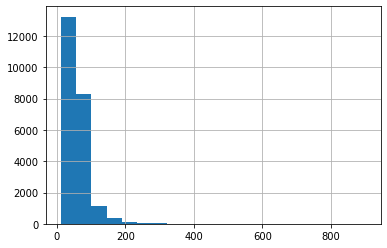

In [82]:
estate['total_area'].hist(bins=20)

Среднее значение в столбце 'total_area' — 61 кв. м, медианное (оно же — 50%) — 52 кв. м, что говорит о значительном влиянии выбросов, то есть квартир с чрезмерно большой площадью. 75% всех квартир обладают площадью меньше 70 кв. м. По одному 1% всех квартир обладают площадью менее 27,3 кв. м или больше 197 кв. м. Построим график типа ящик с усами для визуальной оценки выбросов.

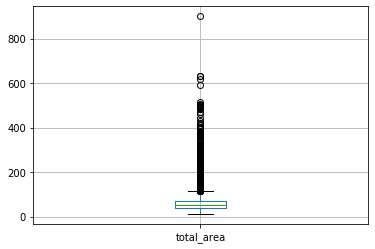

In [83]:
estate.boxplot(column='total_area')

Получим значения столбца, очищенные от выбросов. Для этого воспользуемся формулой, аналогичной той, что используется для вычисления усов графика ящик с усами.

In [84]:
Q1_area = estate['total_area'].quantile(0.25)
Q3_area = estate['total_area'].quantile(0.75)
IQR_area = Q3_area - Q1_area
filtered_area = estate.query('(@Q1_area - 1.5 * @IQR_area) <= total_area <= (@Q3_area + 1.5 * @IQR_area)')
filtered_area['total_area'].describe()

count    22105.000000
mean        54.609935
std         19.266687
min         12.000000
25%         40.000000
50%         50.500000
75%         65.900000
max        114.600000
Name: total_area, dtype: float64

Вот как выглядит столбец 'total_are', очищенный от выбросов. Выбросами оказались все квартиры с площадью более 114 метров, а вот нижняя граница не изменилась — по-прежнему 12 кв. м. Новая медиана равна 50,5 кв. м., новое среднее — 54,6 кв. м.

### Цена

Повторяем действия, описанные выше, для столбца, содержащего информацию о цене.

In [85]:
estate['last_price'].describe()

count    2.333400e+04
mean     6.559042e+06
std      1.086810e+07
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [86]:
estate['last_price'].quantile([0.01, 0.99])

0.01     1000000.00
0.99    35935847.68
Name: last_price, dtype: float64

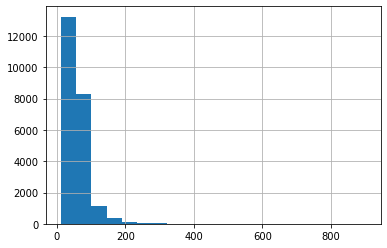

In [87]:
estate['total_area'].hist(bins=20)

Из полученных данных видим, что средняя цена квартиры равна 6 559 042 рублей, медианная — 4 650 000, что (как и в случае с предыдущим столбцом), говорит о влиянии выбросов, причем еще более значительном, чем в случае общей площади. Менее 25% всех квартир продается по цене 3 450 000 рублей и ниже. 75% всех предложений продажи на рынке укладывается в 6 800 000. Лишь 1% всех квартир продается по цене ниже 1 млн. рублей. Топ 1% самых дорогих квартир стоят от 35 935 847 и выше. Построим график типа ящик с усами для визуального определения выбросов.

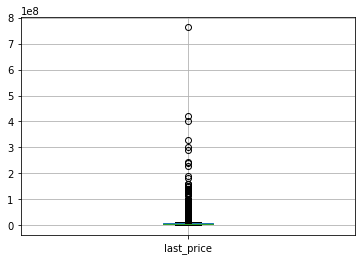

In [88]:
estate.boxplot(column='last_price')

Сразу же видно, насколько большой хвост у этих данных. Значения выбросов настолько велики, что интерквартильный размах на графике становится едва различимым. Очистим столбец от выбросов по описанной выше методике.

In [89]:
Q1_price = estate['last_price'].quantile(0.25)
Q3_price = estate['last_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
filtered_price = estate.query('(@Q1_price - 1.5 * @IQR_price) <= last_price <= (@Q3_price + 1.5 * @IQR_price)')
filtered_price['last_price'].describe()

count    2.128800e+04
mean     4.859157e+06
std      2.214106e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.450000e+06
75%      6.000000e+06
max      1.182000e+07
Name: last_price, dtype: float64

После очистки количество наблюдений уменьшилось почти на 2000. Среднее значение снизилось с 6 559 042 на 4 859 157. Медиана — с 4 650 000 на 4 450 000. Минимальная цена не изменилась, а вот максимальная — заметно уменьшилась и составляет теперь 11 820 000 рублей.

### Число комнат

Проанализируем выборку по числу комнат.

In [90]:
estate['rooms'].describe()

count    23334.000000
mean         2.086698
std          1.064532
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [91]:
estate['rooms'].quantile([0.01, 0.99])

0.01    1.0
0.99    5.0
Name: rooms, dtype: float64

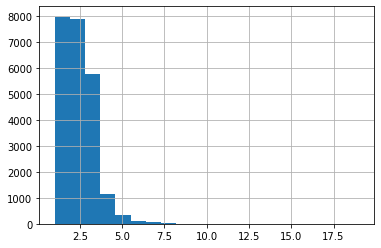

In [92]:
estate['rooms'].hist(bins=20)

Среднее значение в этом столбце до удаления выбросов — 2,09, медианное — 2. Небольшое смещение среднего дает крайне малое количество (в рамках выборки) квартир с непозволительно большим количеством комнат. Ожидаемо, топ 1% квартир с наименьшим количеством комнат имели 1 комнату (так как это минимальное значение). Топ 1% квартир с самым большим количеством комнат — это квартиры, в которых 5 комнат и больше. Рассчитаем границы выбросов, удалим аномальные значения.

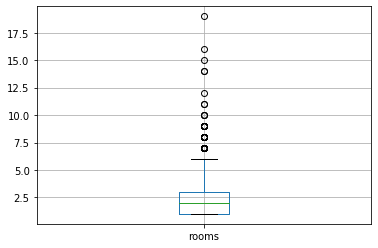

In [93]:
estate.boxplot(column='rooms')

In [94]:
Q1_rooms = estate['rooms'].quantile(0.25)
Q3_rooms = estate['rooms'].quantile(0.75)
IQR_rooms = Q3_rooms - Q1_rooms
filtered_rooms = estate.query('(@Q1_rooms - 1.5 * @IQR_rooms) <= rooms <= (@Q3_rooms + 1.5 * @IQR_rooms)')
filtered_rooms['rooms'].describe()

count    23245.000000
mean         2.063885
std          0.991535
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

Данные приняли куда более единообразный вид. Среднее и медианное значения составляют 2,06 и 2 соответственно, что не слишком расходится с изначальной статистику ввиду небольшого количества выбросов. Минимальное значение осталось таким же, максимальное значение сократилось с 19 до 6.

### Высота потолков

Высота потолков — непростой в данном случае параметр для анализ. Изначально с большим количеством пропусков, этот столбец ожидаемо вернет менее точные результаты даже после удаления выбросов, т. к. любое заполнение пропущенных данных медианными значениями — уже определенная манипуляция с ними. Тем не менее попробуем оценить данный параметр с помощью уже упомянутой методики.

In [95]:
estate['ceiling_height'].describe()

count    23334.000000
mean         2.707416
std          0.230205
min          2.400000
25%          2.550000
50%          2.650000
75%          2.750000
max          5.000000
Name: ceiling_height, dtype: float64

In [96]:
estate['ceiling_height'].quantile([0.01, 0.99])

0.01    2.50
0.99    3.56
Name: ceiling_height, dtype: float64

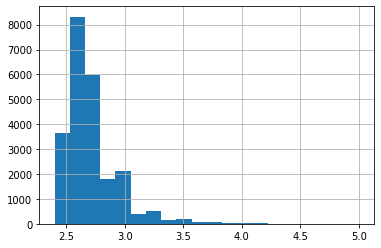

In [97]:
estate['ceiling_height'].hist(bins=20)

На предыдущем этапе работы мы уже провели определенную очистку данных в столбце 'ceiling_height', связанную с наличием откровенно неправдоподобных значений, природу которых сложно или невозможно установить. Также невозможно было сказать, какие из них являлись выбросами, а какие — ошибками в заполнении объявлений продавцами. Своеобразные уступы в районе 3 и 3,5 метров, заметные на гистограмме, — это, скорее всего, медианные значения по группам, на которые мы заменяли пропуски.

Среднее значение до очистки — 2,71 м, медианное — 2,65, что говорит о большем количестве квартир с низкими потолками, чем с высокими. Минимальное и максимальное значения соответствуют выбранным ранее и составляют 2,4 и 5 м соответственно.

Продолжим очистку.

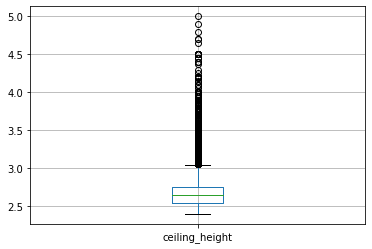

In [98]:
estate.boxplot(column='ceiling_height')

In [99]:
Q1_ceil = estate['ceiling_height'].quantile(0.25)
Q3_ceil = estate['ceiling_height'].quantile(0.75)
IQR_ceil = Q3_ceil - Q1_ceil
filtered_ceil = estate.query('(@Q1_ceil - 1.5 * @IQR_ceil) <= ceiling_height <= (@Q3_ceil + 1.5 * @IQR_ceil)')
filtered_ceil['ceiling_height'].describe()

count    21919.000000
mean         2.665254
std          0.147762
min          2.400000
25%          2.550000
50%          2.650000
75%          2.750000
max          3.050000
Name: ceiling_height, dtype: float64

После очистки данные выглядят следующим образом: все квартиры с высотой потолков более 3,05 м в выборку не попали, минимальное значение осталось таким же. Среднее уменьшилось до 2,67 м, медиана не изменилась.

### Время продажи

Так как время продажи указано не для всех квартир, отсортируем таблицу таким образом, чтобы остались только проданные квартиры (те, у которых столбец 'days_exposition' заполнен) и сохраним их в новом DataFrame. Продолжим анализировать по уже привычному алгоритму.

In [100]:
estate_time = estate.query('days_exposition != "NaN"')
len(estate_time)

20188

In [101]:
estate_time['days_exposition'].describe()

count    20188.000000
mean       181.672231
std        220.209035
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [102]:
estate['days_exposition'].quantile([0.01, 0.99])

0.01       4.00
0.99    1069.13
Name: days_exposition, dtype: float64

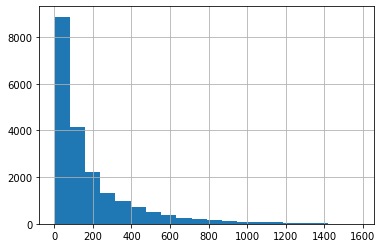

In [103]:
estate['days_exposition'].hist(bins=20)

Значения в столбце варьируются от 1 до 1 580 дней. Среднее и медианное значения равны 182 и 96 дням соответственно. Такую разницу можно объяснить тем, что часть квартир продается очень долго (максимум — дольше 4-х лет). Очистим столбец от выбросов.

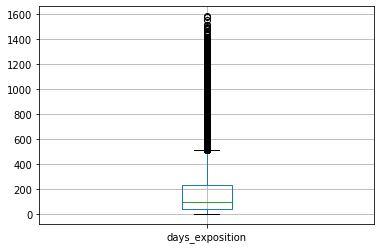

In [104]:
estate.boxplot(column='days_exposition')

In [105]:
Q1_days = estate['days_exposition'].quantile(0.25)
Q3_days = estate['days_exposition'].quantile(0.75)
IQR_days = Q3_days - Q1_days
filtered_days = estate.query('(@Q1_days - 1.5 * @IQR_days) <= days_exposition <= (@Q3_days + 1.5 * @IQR_days)')
filtered_days['days_exposition'].describe()

count    18537.000000
mean       129.252090
std        121.723866
min          1.000000
25%         42.000000
50%         86.000000
75%        183.000000
max        512.000000
Name: days_exposition, dtype: float64

Заметно, как сильно изменился разброс значений в столбце после удаления аномальных значений. Минимальное значение не изменилось, а вот максимум снизился до 512 дней, то есть в три раза. Разрыв между медианой и средним остается по прежнему очень значительным (куда больше, чем для других изученных параметров). Новое среднее — 129 дней, новая медиана — 86 дней.

Быстрой продажей можно назвать случаи, попавшие в первую квартиль, то есть те квартиры, которые были проданы за 42 дня и менее. К долгой продаже можем отнести квартиры, которые продавались более 183 дней (то есть, после третьей квартили).

Отсортированные значения можно было бы сохранять в новый общий или в первоначальный DataFrame, но это приведет к существенному снижению общего количества наблюдений в выборке, поэтому удобнее для оценки каждого отдельного фактора пользоваться отдельным DataFrame, очищенным от конкретных значений.

### Факторы

В рамках задания необходимо установить степень влияния отдельных факторов на цену квартиры: *стоимости квадратного метра, числа комнат, удалённости от центра, этажности и даты размещения (дня недели, месяца и года)*.

Каждый из факторов, влияние которых необходимо установить на цену квартиры, будем рассматривать на примере соответствующего DataFrame с уже подготовленным данными.

Начнем со стоимости квадратного метра. Рассчитаем коэффициент корреляции между столбцами 'last_price' и 'sqm_price'.

#### Стоимость квадратного метра

In [106]:
filtered_price['last_price'].corr(filtered_price['sqm_price'])

0.6156066179491247

Коэффициент корреляции Пирсона равен 0,62, что говорит о наличии слабой положительной линейной связи. Проверим это предположение, взглянув на график разброса.

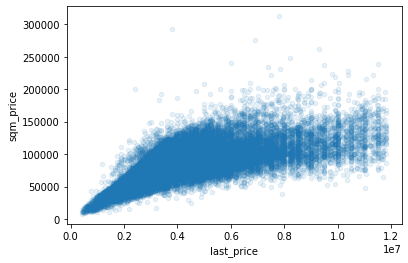

In [107]:
filtered_price.plot(x='last_price', y='sqm_price', kind='scatter', alpha=0.1)

Действительно, заметно наличие определенной связи между ценой квадратного метра квартиры и ценой квартиры как таковой. Это кажется вполне логичным, ведь квартиры с одинаковой площадью, но разной стоимостью квадратного метра будут стоить по-разному. Однако это не единственный фактор, влияющий на цены квартиры (их несколько), поэтому коэффициент корреляции Пирсона остается относительно низким.

Перейдем к числу комнат. Для этого сначала составим общий DataFrame, в который войдут отфильтрованные значения цены и количества комнат и удалим из него пропущенные значения.

In [108]:
price_rooms = pd.concat([filtered_price['last_price'], filtered_rooms['rooms']], axis=1)
price_rooms = price_rooms.dropna()

In [109]:
price_rooms['last_price'].corr(price_rooms['rooms'])

0.4490125910646859

Связь в данном случае гораздо слабее. Убедимся в этом, исследовав график.

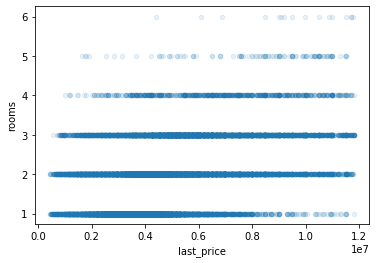

In [110]:
price_rooms.plot(x='last_price', y='rooms', kind='scatter', alpha=0.1)

Судя по коэффициенту корреляции и графику выше, связь действительно есть, но слабая. Квартира с любым количеством комнат может оказаться как дешевой, так и дорогой, но чем больше количество комнат, тем выше вероятность того, что квартира окажется относительно дорогой. Рассчитаем медианные значения цены для квартир в зависимости от количества комнат.

In [111]:
price_rooms.groupby('rooms')['last_price'].median()

rooms
1.0    3600000.0
2.0    4650000.0
3.0    5700000.0
4.0    6999000.0
5.0    8994500.0
6.0    9745000.0
Name: last_price, dtype: float64

Если судить по медианным значениям, медианная цена квартиры увеличивается с каждой дополнительной комнатой. Однако, как уже было сказано выше, это явно не основной фактор, определяющий стоимость квартиры. Значит, более значимыми являются другие факторы. Взглянем на связь между ценой и удаленностью от центра. Снова обратимся к таблице с ценами, из которой уже удалены все выбросы — filtered_price.

#### Расстояние до центра

In [112]:
filtered_price['last_price'].corr(filtered_price['cityCenters_nearest'])

-0.34756015924600325

Между ценой квартиры и расстоянием до центра города присутствует некоторая отрицательно связь, хоть и очень слабая. Значит, чем дальше квартира от центра, тем ниже ее цена (что логично). По графику рассеяния при этом можно сказать, что образовалось несколько групп наблюдений, которые, скорее всего, соответствуют различным населенным пунктам.

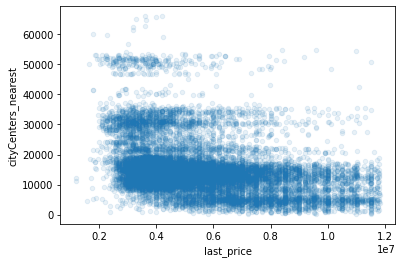

In [113]:
filtered_price.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=0.1)

In [114]:
filtered_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21288 entries, 1 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21288 non-null  int64         
 1   last_price            21288 non-null  int32         
 2   total_area            21288 non-null  float64       
 3   first_day_exposition  21288 non-null  datetime64[ns]
 4   rooms                 21288 non-null  int64         
 5   ceiling_height        21288 non-null  float64       
 6   floors_total          21288 non-null  int32         
 7   living_area           21288 non-null  float64       
 8   floor                 21288 non-null  int64         
 9   is_apartment          2501 non-null   object        
 10  studio                21288 non-null  bool          
 11  open_plan             21288 non-null  bool          
 12  kitchen_area          21288 non-null  float64       
 13  balcony         

Взглянем более подробно на данные для Санкт-Петербурга.

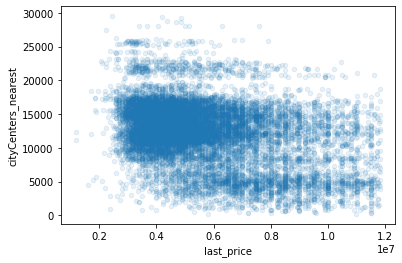

In [115]:
filtered_price_spb = filtered_price.query('locality_name == "Санкт-Петербург"').copy()
filtered_price_spb.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=0.1)

Сравнивая гистограммы для всей выборки в целом и Петербурга в отдельности можно заметить, что для последнего характерно наличие куда большего (в процентном соотношении) количества объектов недвижимости в непосредственной близости от центра города. Это связано с тем, что расстояния для прочих населенных пунктов считаются не от центра соответствующего населенного пункта, а от центра Петербурга.

Визуально выборка для Петербурга делится на несколько частей. Граница между нижней частью (тем самым центром) и остальной выборкой визуально проходит на уровне 6000 метров. Следовательно, все, что попадает в шестикилометровый радиус, может считаться центром Петербурга.

Чтобы точнее определить границу центра города, произведем следующие вычисления: создадим столбец с расстоянием до центра в километрах, округленным до целых значений. После этого посчитаем среднюю цену для каждого километра.

In [116]:
filtered_price_spb['center_round'] = 1000 * (filtered_price_spb['cityCenters_nearest'] // 1000)
filtered_price_spb.groupby('center_round')['last_price'].median()

center_round
0.0        8500000
1000.0     8280000
2000.0     7780000
3000.0     7425000
4000.0     7700000
5000.0     7350000
6000.0     6500000
7000.0     6325000
8000.0     5800000
9000.0     4800000
10000.0    4870000
11000.0    4900000
12000.0    4900000
13000.0    5100000
14000.0    4795000
15000.0    4799500
16000.0    4600000
17000.0    4422789
18000.0    4300000
19000.0    4500000
20000.0    6140000
21000.0    4700000
22000.0    5000000
23000.0    3950000
24000.0    3480000
25000.0    3499000
26000.0    3975000
27000.0    2250000
28000.0    4775000
29000.0    4200000
Name: last_price, dtype: int32

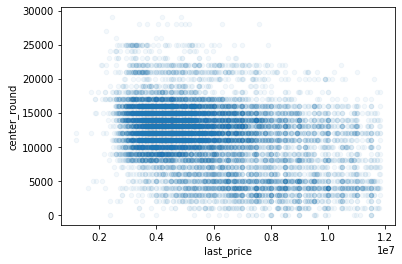

In [117]:
filtered_price_spb.plot(x='last_price', y='center_round', kind='scatter', alpha=0.05)

Визуальная граница между центром города, где расстояния до центра ниже, а цены выше, и остальным городом, где расстояние до центра выше, а разброс цен больше, проходит по уровню 6 км. Если пользоваться данным методом анализа, то это и будет граница, отделяющая центр Петербурга от остального города.

Выделить центральный район города можно и другим способом. Для этого разобьем все наблюдения на десять равных групп и оценим медианную цену для каждой из них. По сути, метод используют ту же логику, но образует группы несколько иначе. Кроме того, увеличивая и уменьшая количество групп можно более детально оценить уровень цен на той или иной удаленности от центра.

In [118]:
filtered_price_spb.dropna(subset=['cityCenters_nearest'], inplace=True)
filtered_price_spb['last_price'].corr(filtered_price_spb['cityCenters_nearest'])

-0.3662401016891062

Коэффициент корреляции указывает на наличие слабой линейной связи между расстоянием до центра и ценой квартир, однако он не в состоянии учитывать другие виды связи.

In [119]:
filtered_price_spb['cut'] = pd.qcut(filtered_price_spb['cityCenters_nearest'], q=10)
filtered_price_spb.groupby('cut')['last_price'].median()

cut
(207.999, 5080.0]     7600000
(5080.0, 8462.0]      6700000
(8462.0, 10680.0]     4900000
(10680.0, 11825.0]    4850000
(11825.0, 12696.5]    4950000
(12696.5, 13732.0]    5000000
(13732.0, 14768.0]    4850000
(14768.0, 15723.0]    4800000
(15723.0, 16921.0]    4600000
(16921.0, 29493.0]    4500000
Name: last_price, dtype: int32

По полученным данным можно сказать, что цена в непосредственной близости от центра выше, чем на определенном удалении от нее. При этом, после определенного значения цена перестает снижаться и остается приблизительно одинаковой при все большем удалении от центра города. Значит, в данном случае коэффициент корреляции Пирсона не является адекватным инструментом анализа.

In [120]:
filtered_price_spb['last_price'].median()

5150000.0

Разобьем все квартиры в Петербурге на десять равных групп по удаленности от центра города. Посчитаем медианную цену для каждой из них. Видим, что в диапазоне от 208 до 5080 медианная цена составляет 7 600 000 рублей, в то время как в среднем по городу она равна 5 150 000 рублей. Для квартир, которые располагаются на расстоянии от 5080 до 8462 от центра медианное значение цены равно 6 700 000 рублей. Во всех прочих группах это значение меньше или равно 5 000 000 рублей. Следовательно, при использовании подобного метода исследования, в центре города будут располагаться квартиры, находящиеся в радиусе 8472 метров. Увеличим количество групп для более точного определения границы между центром и остальными частями города.

In [121]:
filtered_price_spb['cut'] = pd.qcut(filtered_price_spb['cityCenters_nearest'], q=50)
filtered_price_spb.groupby('cut')['last_price'].median()

cut
(207.999, 2433.0]     8250000
(2433.0, 3525.0]      7400000
(3525.0, 4184.0]      7500000
(4184.0, 4670.0]      7750000
(4670.0, 5080.0]      7424000
(5080.0, 5614.0]      7515162
(5614.0, 6201.0]      6700000
(6201.0, 7211.0]      6500000
(7211.0, 8059.0]      6370000
(8059.0, 8462.0]      6110000
(8462.0, 9049.0]      5400000
(9049.0, 9508.0]      4800000
(9508.0, 9893.5]      4750000
(9893.5, 10352.0]     4990000
(10352.0, 10680.0]    4850000
(10680.0, 10944.0]    4950000
(10944.0, 11199.5]    4685000
(11199.5, 11409.0]    4950000
(11409.0, 11627.5]    4820000
(11627.5, 11825.0]    4900000
(11825.0, 11977.0]    5000000
(11977.0, 12139.0]    4855000
(12139.0, 12291.5]    5000000
(12291.5, 12482.0]    4750000
(12482.0, 12696.5]    5100000
(12696.5, 12921.0]    4900000
(12921.0, 13118.0]    4980000
(13118.0, 13286.0]    5355000
(13286.0, 13496.0]    5200000
(13496.0, 13732.0]    4625000
(13732.0, 13955.0]    5050000
(13955.0, 14157.0]    4900000
(14157.0, 14402.0]    4762500
(14402

При увеличении количества групп граница несколько смещается, но общая тенденция остается прежней. Отсекаем квартиры, цены на которые перестают меняться в зависимости от удаленности от центра и остаются в диапазоне от 4 000 000 до 6 000 000, то есть все квартиры удаленностью более 8 462 метров.

Сверимся с картой. Для этого воспользуемся сервисом Круг: https://tech.yandex.ru/maps/jsbox/2.1/circle. Центром круга задаем Дворцовую площадь с координатами 59.93, 30.31.

http://prntscr.com/qc2bh0

Заметно, что в центр города по такой классификации попали не только Центральный, Василеостровский, Петроградский, и Адмиралтейский районы, но и часть Кировского (до ст. м. Автово), Приморского (до ст. м. Старая Деревня), Калининского (до ст. м. Площадь Мужества) и Красногвардейского (до ст. м. Новочеркасская) районов города. Очевидно, что многие из этих мест не относятся к центру города. Скорее, эта группа квартир может быть классифицирована как "не слишком далеко от центра" или "не окраина города".

Сократим радиус до 5 614 метров — начиная с этой группы медианная цена квартир станет превышать 7 миллионов рублей. Центр круга тот же.

http://prntscr.com/qc2cbg

Видим, что внутри круга оказалось куда меньше лишнего. Немного сдвинем центр круга — на 59.93, 30.30 — и получим область, в которую вошли центр и объекты в непосредственной близости от него. Остановимся на значении 5 614 метров.

http://prntscr.com/qc2d2u

#### Этаж

Для работы с коэффициентом корреляции и гистограммой переведем категории "первый", "последний", "другой" в числа: 1, 3 и 2 соответственно. Для этого создадим новый столбец 'floor_cats_num' и сохраним значения в него.

In [122]:
filtered_price.loc[filtered_price['floor_cats'] == "первый", 'floor_cats_num'] = 1
filtered_price.loc[filtered_price['floor_cats'] == "другой", 'floor_cats_num'] = 2
filtered_price.loc[filtered_price['floor_cats'] == "последний", 'floor_cats_num'] = 3

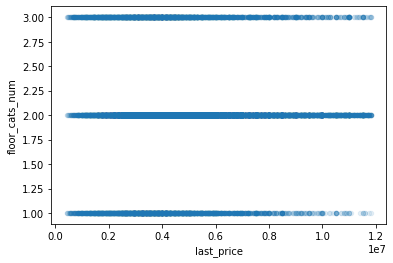

In [123]:
filtered_price.plot(x='last_price', y='floor_cats_num', kind='scatter', alpha=0.1)

По такой гистограмме сложно сделать однозначные выводы, однако можно сказать, что на первом и последнем этажах меньше дорогих квартир. Посчитаем коэффициент корреляции.

In [124]:
filtered_price['last_price'].corr(filtered_price['floor_cats_num'])

0.032640110890928296

Коэффициент корреляции практически равен нулю. Можно с уверенностью заявить, что этот параметр крайне слабо влияет на цену квартир.

#### Дата размещения

Изучим зависимость цены от даты размещения: дня недели, месяца и года.

In [125]:
filtered_price['last_price'].corr(filtered_price['pub_day'])

-0.014940114648012367

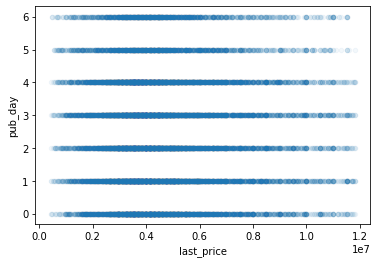

In [126]:
filtered_price.plot(x='last_price', y='pub_day', kind='scatter', alpha=0.05)

Здесь 0 — это первый день недели, а 6 — последний. Коэффициент корреляции стремится к нулю, график также говорит об отсутствии связи. Следовательно, день недели, в который было опубликовано объявление, никак не влияет на стоимость квартиры. Повторим те же операции для месяца и года публикации.

In [127]:
filtered_price['last_price'].corr(filtered_price['pub_month'])

0.00749312654061404

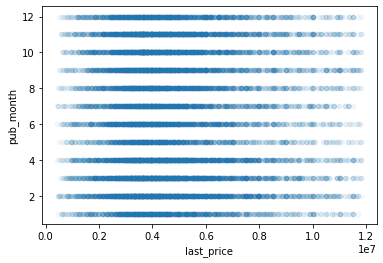

In [128]:
filtered_price.plot(x='last_price', y='pub_month', kind='scatter', alpha=0.05)

Результаты примерно такие же, как и для дня недели: месяц публикации и цена квартиры никак между собой не связаны.

In [129]:
filtered_price['last_price'].corr(filtered_price['pub_year'])

-0.0012678475357295646

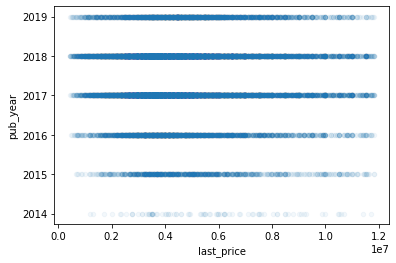

In [130]:
filtered_price.plot(x='last_price', y='pub_year', kind='scatter', alpha=0.05)

Картина для года публикации объявления выглядит несколько иначе. Несмотря на то, что каждый год, начиная с 2015, на рынке появляются квартиры во всех ценовых диапазонах, сверхдорогих и сверхдешевых квартир в 2015 и 2019 годах меньше, чем во всех остальных (понять это можно, оценив плотность расположения точек на диаграмме рассеяния).

Возможно, сказывается общий неблагоприятный экономический климат в стране. Возможно, вмешиваются специфические для Петербурга и ЛО факторы. Для того, чтобы сказать наверняка, имеющихся данных недостаточно.

### Населенный пункт

Получим список 10 наиболее часто упоминаемых в объявлениях населенных пунктов и рассчитаем для них усредненные цены квартир и квадратного метра.

In [131]:
filtered_price.pivot_table(index='locality_name', values=['last_price', 'sqm_price'], aggfunc=('count', 'mean', 'median')).sort_values(by=('sqm_price','count'), ascending=False).head(10)

last_price                          sqm_price  \
                       count          mean     median     count   
locality_name                                                     
Санкт-Петербург      13526.0  5.682656e+06  5150000.0     13526   
посёлок Мурино         493.0  3.739857e+06  3450000.0       493   
Кудрово                446.0  4.404085e+06  3945000.0       446   
посёлок Шушары         435.0  4.124726e+06  3990000.0       435   
Всеволожск             388.0  3.771874e+06  3500000.0       388   
Пушкин                 338.0  5.334385e+06  4970000.0       338   
Колпино                336.0  3.839849e+06  3600000.0       336   
посёлок Парголово      323.0  4.514073e+06  4140000.0       323   
Гатчина                304.0  3.423419e+06  3085000.0       304   
Выборг                 234.0  3.189286e+06  2898500.0       234   

                                                 
                            mean         median  
locality_name                                    
Санкт-Петербург    105310.451382  101754.385965  
посёлок Мурино      85076.238902   84285.714286  
Кудрово             94900.635628   95133.576199  
посёлок Шушары      78277.935520   76666.666667  
Всеволожск          67281.171559   65789.473684  
Пушкин             100290.598633   98325.892857  
Колпино             75185.478229   74689.878234  
посёлок Парголово   90289.778393   91917.591125  
Гатчина             68432.443926   67746.286082  
Выборг              58027.737264   58233.006089

В топ 3 самых дорогих квартир (как по средней, так и по медианной цене) попали Санкт-Петербург, Пушкин и поселок Парголово.

В топ 3 самых дешевых квартир (как по средней, так и по медианной цене) вошли Выборг, Гатчина и поселок Мурино.

Цена квадратного метра оказалась максимальной в Санкт-Петербурге и составила 101 754 рублей. Минимальной — в Выборге, 58 233 рублей. Цены квадратного метра в Пушкине, Парголово, Гатчине и Мурино составили соответственно: 98 325, 91 917, 67 746 и 84 285 рублей.

### Квартиры в центре

Проанализируем квартиры в центре. Насколько они отличаются от всех остальных предложений? Для этого возьмем квартиры в Санкт-Петербурге с удаленностью от центра не более чем на 5 700 метров (значение берем из уже проведенного нами анализа). Сравним общую площадь квартир.

In [132]:
print('Медиана и среднее общей площади для квартир в центре:')
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'total_area'].median())
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'total_area'].mean())
print()

print('Медиана и среднее общей площади для всех квартир в Петербурге:')
print(filtered_price_spb['total_area'].median())
print(filtered_price_spb['total_area'].mean())

Медиана и среднее общей площади для квартир в центре:
68.0
70.31749848576625

Медиана и среднее общей площади для всех квартир в Петербурге:
50.8
54.91883483661082


Заметно, насколько выше общая площадь квартир  в центре по сравнению с этим же значением в среднем по городу. Это объясняется тем, что недвижимость в центре дороже. Бюджетное жилье с меньшим метражом строится на окраинах, в то время как в более дорогих районах и общая площадь квартир будет больше. Сравним цены.

In [133]:
print('Медиана и среднее цены для квартир в центре:')
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'last_price'].median())
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'last_price'].mean())
print()

print('Медиана и среднее цены для всех квартир в Петербурге:')
print(filtered_price_spb['last_price'].median())
print(filtered_price_spb['last_price'].mean())

Медиана и среднее цены для квартир в центре:
7600000.0
7674618.407026045

Медиана и среднее цены для всех квартир в Петербурге:
5150000.0
5682656.127458229


Квартиры в центре заметно дороже тех, что расположены за его пределами. Объясняется это теми же факторами, что и в предыдущем пункте: престижность, удобство расположения, больший метраж квартир. Сравним количество комнат.

In [134]:
print('Медиана и среднее числа комнат для квартир в центре:')
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'rooms'].median())
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'rooms'].mean())
print()

print('Медиана и среднее числа комнат для всех квартир в Петербурге:')
print(filtered_price_spb['rooms'].median())
print(filtered_price_spb['rooms'].mean())

Медиана и среднее числа комнат для квартир в центре:
2.0
2.490006056935191

Медиана и среднее числа комнат для всех квартир в Петербурге:
2.0
1.9883927251219873


Медианные значения одинаковы (т. к. число комнат — всегда целое число) и равны 2, а вот среднее различается очень существенно. Квартиры в центре в среднем имеют на полкомнаты больше, чем в среднем по городу. Объясняется это расхождение факторами, уже описанными выше.

In [135]:
print('Медиана и среднее высоты потолков для квартир в центре:')
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'ceiling_height'].median())
print(filtered_price_spb.loc[filtered_price_spb['cityCenters_nearest'] < 5700, 'ceiling_height'].mean())
print()

print('Медиана и среднее высоты потолков для всех квартир в Петербурге:')
print(filtered_price_spb['ceiling_height'].median())
print(filtered_price_spb['ceiling_height'].mean())

Медиана и среднее высоты потолков для квартир в центре:
3.0
2.9679164142943777

Медиана и среднее высоты потолков для всех квартир в Петербурге:
2.65
2.6981502291881916


В среднем потолки в квартирах в центре также заметно выше, что объясняется наличием большого количества зданий из старого фонда, где высота потолков выше, чем в новых домах.

### Вывод

На заключительном этапе работы удалось рассчитать ряд ключевых значений, заявленных как цель проведения данного исследования.

В ходе анализа:

- избавились от аномальных значений(выбросов), после чего рассчитали площадь, цену, число комнат и высоту потолков, характерные для рынка недвижимости Санкт-Петербурга и Ленинградской области в 2014–2019 гг., снабдив расчеты графиками и необходимыми пояснениями.

- подсчитали время продажи квартиры и выяснили, какие сроки продажи квартиры можно считать приемлемыми, а какие аномально длинными (от 183 дней и более) и короткими (до 42 дней).

- установили связь между рядом параметров и ценой квартиры, выяснив, что наибольшее влияние на цену квартиры имеют стоимость квадратного метра, число комнат и удаленность от центра (для последнего связь имеет нелинейный характер).

- нашли 3 населенных пункта с самыми дорогими и 3 населенных пункта с самыми дешевыми квартирами из списка 10 наиболее часто встречающихся в выборке. Самые дорогие квартиры в Санкт-Петербурге, Пушкине и Парголово. Самые дешевые — в Выборге, Гатчине и Мурино.

- определили радиус окружности, внутри который находится центр Санкт-Петербурга. Его величина составила порядка 5 700 м.

- наконец, сравнили квартиры в центре Петербурга со среднегородскими значениями по ряду параметров: площадь, цена, число комнат, высота потолков. Квартиры в центре в среднем имеют более высокие потолки, большее количество комнат и стоят дороже.

## Шаг 5. Общий вывод

В рамках выполнения проекта мы подготовили данные, удалив некорректные значения, заполнили пропуски (там где это было возможно) или оставили их пустыми (если адекватно заполнить пропущенные значения не представлялось возможным), а также изменили тип данных нескольких столбцов на более подходящий.

На основе очищенных данных мы рассчитали цену квадратного метра, день недели, месяц и год публикации объявления, этаж квартиры (первый, последний, другой), соотношение жилой и общей площади, а также отношение площади кухни к общей площади квартиры.

На следующем этапе работы, анализируя графики и коэффициенты корреляции Пирсона, мы выяснили, какие факторы имеют наибольшее влияние на цену квартиры. Оказалось, что это стоимость квадратного метра, число комнат и удаленность от центра. Здесь же определили 3 населенных пункта с самыми дорогими и 3 населенных пункта с самыми дешевыми квартирами из списка 10 наиболее популярных для данной выборки.

На завершающем этапе по собственным критериям определили границу центра Петербурга и сравнили объекты недвижимости, расположенные внутри данной границы со средними значениями для всего города. Квартиры в центре в среднем имеют более высокие потолки, большее количество комнат и стоят дороже.